In [80]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt
import pathlib
import os
from statsmodels.tsa.ar_model import AutoRegResults

In [9]:
path_data = '../data/data combined (aqcin)/combined aqicn data (all german cities).csv'

In [10]:
df_data_all_cities = pd.read_csv(path_data)

In [11]:
df_data = df_data_all_cities.copy()

In [12]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_data.sort_values(by='date', ascending=True, inplace=True)
df_data.rename(columns={' pm10':'pm10', ' pm25':'pm25'}, inplace=True)
df_data.replace(' ', np.nan, inplace=True) 
df_data['pm10'] = pd.to_numeric(df_data['pm10']) # , downcast='float'
df_data['pm25'] = pd.to_numeric(df_data['pm25']) # , downcast='float'
df_data.replace({'munich':'Munich','berlin,-germany':'Berlin',
            'potsdam-zentrum,-germany':'Potsdam',
            'hannover,-germany':'Hannover',
            'stuttgart-bad-cannstatt, germany':'Stuttgart',
            'dresden-bergstraße,-germany':'Dresden',
            'sternschanze,-hamburg, germany':'Hamburg',
            'frankfurt-schwanheim,-germany':'Frankfurt',
            'kiel-bahnhofstr.-verk., schleswig-holstein, germany':'Kiel'}, inplace=True )

In [13]:
# drop nan values
df_data.dropna(axis = 0, inplace = True)

In [14]:
df_data.isnull().sum()

date    0
city    0
pm25    0
pm10    0
dtype: int64

In [15]:
# convert string columns into numeric 
df_data['pm25'] = pd.to_numeric(df_data['pm25'], errors='coerce')
df_data['pm10'] = pd.to_numeric(df_data['pm10'], errors='coerce')

In [16]:
df_data.reset_index(drop = True, inplace = True)

In [18]:
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

In [19]:
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

In [35]:
city = 'Berlin'
target_col = 'pm25'
df_city = df_data[df_data['city'] == city]

In [39]:
df_city.set_index('date', inplace = True)

In [40]:
df_city_pm25 = df_city[[target_col]]

In [63]:
df_city_pm25

,pm25
date,
2022-08-31,19.0
2022-09-01,17.0
2022-09-02,19.0
2022-09-03,21.0
2022-09-04,25.0
...,...
2023-12-23,28.0
2023-12-24,29.0
2023-12-25,29.0


In [62]:
X_pm25

array([[ -2.],
       [  2.],
       [  2.],
       [  4.],
       [ 15.],
       [ -3.],
       [ 15.],
       [  6.],
       [-21.],
       [ -4.],
       [ 30.],
       [-30.],
       [  9.],
       [  4.],
       [  1.],
       [ -6.],
       [-11.],
       [ -2.],
       [  2.],
       [  0.],
       [  6.],
       [  5.],
       [ 17.],
       [  7.],
       [  1.],
       [-24.],
       [ -5.],
       [  5.],
       [ 13.],
       [  9.],
       [ -9.],
       [-14.],
       [  0.],
       [  0.],
       [  7.],
       [ -8.],
       [ 16.],
       [ -4.],
       [ -8.],
       [  5.],
       [ -2.],
       [ 15.],
       [ 15.],
       [  6.],
       [-23.],
       [-16.],
       [ 13.],
       [  6.],
       [-25.],
       [ 10.],
       [ 14.],
       [  2.],
       [-12.],
       [  0.],
       [ -1.],
       [  7.],
       [  3.],
       [  0.],
       [ 11.],
       [ 24.],
       [  7.],
       [-20.],
       [-35.],
       [  4.],
       [ 12.],
       [ -7.],
       [ -

In [44]:
# split dataset
X_pm25 = difference(df_city_pm25.values)

In [45]:
size = int(len(X_pm25) * 0.7)
train_pm25, test_pm25 = X_pm25[0:size], X_pm25[size:]

In [46]:
# train autoregression
window = 6
model = AutoReg(train_pm25, lags=6)
model_fit = model.fit()
coef = model_fit.params

In [54]:
# walk forward over time steps in test
history = [train_pm25[i] for i in range(len(train_pm25))]
predictions_pm25 = list()
for t in range(len(test_pm25)):
    yhat = predict(coef, history)
    obs = test_pm25[t]
    predictions_pm25.append(yhat)
    history.append(obs)

rmse = sqrt(mean_squared_error(test_pm25, predictions_pm25))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.504


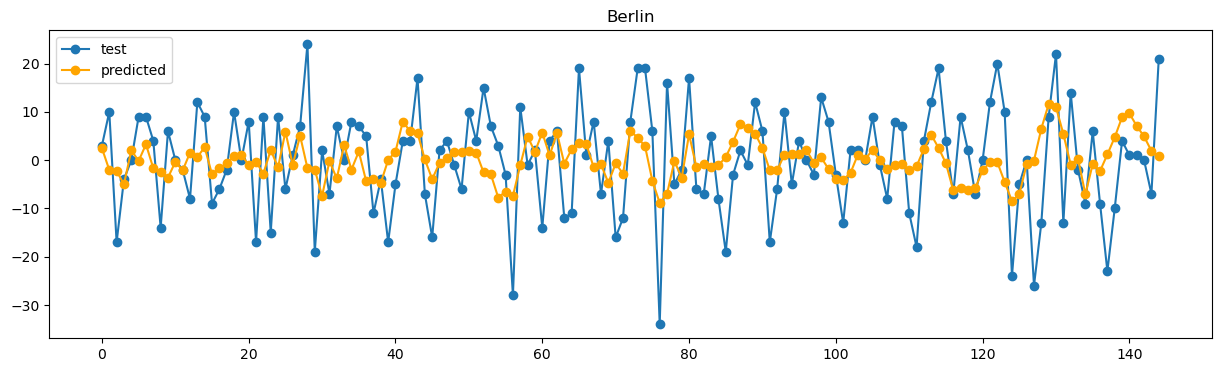

In [64]:
# plot
plt.figure(figsize = (15, 4))
plt.plot(test_pm25, marker = 'o', label = 'test')
plt.plot(predictions_pm25, marker = 'o', label = 'predicted', color='orange')
plt.title(f'{city}')
plt.legend()
plt.show()